In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import requests
from collections import Counter
from IPython.core.display import HTML
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

c:\users\ryana\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
HTML("<h1 align='center'>State of the World with COVID-19</h1>")

In [2]:
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

In [4]:
url = "https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_daily_reports/"

In [5]:
soup = BeautifulSoup(requests.get(url).text)

In [6]:
timeline_csvs = soup.select("a[href$='.csv']")
last_date = dt.datetime.strptime(timeline_csvs[-1]['href'].split("/")[-1][:-4],"%m-%d-%Y")
HTML("<h2 align='center'>Start Date: "+timeline_csvs[0]['href'].split("/")[-1][:-4]+"</h2>"\
     "<h2 align='center'>End Date: "+timeline_csvs[-1]['href'].split("/")[-1][:-4]+"</h2>")

In [7]:
def update_countries(df):
    misspelled_countries = ["Taiwan","China","Russia","Bahamas","Gambia","Hong Kong","Iran","Moldova","Ireland","Taipei"]
    
    df.loc[(df['Country_Region']=="Macao SAR") | (df['Country_Region']=="Macau"),"Country_Region"] = "Macao"
    df.loc[(df['Country_Region']=="Republic of Korea") | (df['Country_Region']=="Korea, South"),"Country_Region"] = "South Korea"
    df.loc[(df['Country_Region']=="West Bank and Gaza") | (df['Country_Region'].str.contains("Palestin")),"Country_Region"] = "Palestinian Territory"
    df.loc[df['Country_Region']=="UK","Country_Region"] = "United Kingdom"
    df.loc[df['Country_Region']=="US","Country_Region"] = "United States"
    df.loc[df['Country_Region']=="Viet Nam","Country_Region"] = "Vietnam"
    df.loc[df['Country_Region']=="Burma","Country_Region"] = "Myanmar"
    df.loc[df['Country_Region']=="Cape Verde","Country_Region"] = "Cabo Verde"
    df.loc[df['Country_Region'].str.contains("Czech"),"Country_Region"] = "Czechia"
    df.loc[df['Country_Region'].str.startswith("Congo"),"Country_Region"] = "Congo"
    
    for country in range(len(misspelled_countries)):
        df.loc[df['Country_Region'].str.contains(misspelled_countries[country]),"Country_Region"] = misspelled_countries[country]
    
    return df


In [8]:
df = pd.DataFrame()
country_counts = Counter()
for each in range(len(timeline_csvs)):
    csv_date = timeline_csvs[each]['href'].split("/")[-1][:-4]
    time_slice = pd.read_html(url + csv_date + ".csv")[0]
    time_slice.columns = time_slice.columns.str.replace("/","_")
    time_slice = update_countries(time_slice)
    for country in time_slice['Country_Region'].unique():
        country_counts[country] += 1
    if len(time_slice.columns) != 13:
        if len(time_slice.columns) == 9:
            del time_slice['Latitude']
            del time_slice['Longitude']
        del time_slice['Unnamed: 0']
        del time_slice['Last Update']
        time_slice['Active'] = time_slice['Confirmed'] - time_slice['Deaths'] - time_slice['Recovered']
        time_slice['Date'] = dt.datetime.strptime(csv_date,"%m-%d-%Y")
    else:
        del time_slice['Unnamed: 0']
        del time_slice['Lat']
        del time_slice['Long_']
        del time_slice['Last_Update']
        del time_slice['Combined_Key']
        del time_slice['FIPS']
        del time_slice['Admin2']
        time_slice['Date'] = dt.datetime.strptime(csv_date,"%m-%d-%Y")
    df = df.append(time_slice)

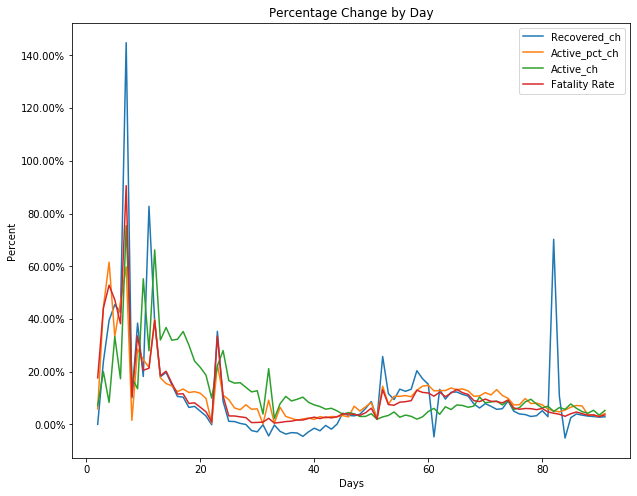

In [33]:

# df = pd.read_sql("SELECT * FROM covid_data",app.config['SQLALCHEMY_DATABASE_URI'], parse_dates=['Date'])

confirmed_df = df.groupby(["Country_Region","Date"])['Confirmed'].sum().unstack().sort_values(df.Date.max(), ascending = False)
death_df = df.groupby(["Country_Region","Date"])['Deaths'].sum().unstack().sort_values(df.Date.max(), ascending = False).loc[[x for x in confirmed_df.nlargest(10,df.Date.max()).replace(0,np.NaN).index]]#.nlargest(10,df.Date.max())
totals = df.groupby("Date").sum().reset_index(drop=True)
rates_df = df.groupby("Country_Region").sum()

confirmed_df = confirmed_df.nlargest(10,df.Date.max()).replace(0,np.NaN)

totals.index = totals.index + 1
for col in totals:
    totals[col+'_pct_ch'] = totals[col].pct_change()
    totals[col+'_ch'] = totals[col].diff()
totals['Fatality Rate'] = totals['Deaths'] / totals['Confirmed']
# print("totals columns",totals.columns)

aggs = pd.DataFrame(totals[['Confirmed','Deaths','Recovered','Active']])
# print("aggs columns",aggs.columns)
aggs['Fatality Rate'] = aggs['Deaths'] / aggs['Confirmed']
aggs['Active'] = aggs['Confirmed'] - aggs['Deaths'] - aggs['Recovered']

rates_df['Fatality Rate'] = rates_df['Deaths']/rates_df['Confirmed']
# print("rates columns",rates_df.columns)

top_ten_df = rates_df.loc[rates_df['Confirmed']>1000].nlargest(10,"Fatality Rate")
# print("top ten df columns",top_ten_df.columns)

yesterdays_numbers = totals[['Confirmed_ch','Deaths_ch','Recovered_ch','Active_ch']]
yesterdays_numbers = pd.DataFrame(yesterdays_numbers.iloc[-1]).T
yesterdays_numbers.columns = yesterdays_numbers.columns.str[:-3]
# print('yesterdays columns',yesterdays_numbers.columns)

def hover(hover_color="#ffff99"):
        return dict(selector="tr:hover",
            props=[("background-color", "%s" % hover_color)])
            
styles = [
        hover(),
        dict(selector="th", props=[("font-size", "150%"),
                                ("text-align", "center")]),
        dict(selector="td", props=[("text-align", "center")]),
        dict(selector="caption", props=[("caption-side", "bottom")]),
        dict(selector="table",props=[("margin-left","auto"),
                                    ("margin-right","auto"),
                                    ("background-color","white")])
    ]
aggs_html = "<h2 align='center'>Start Date: "+timeline_csvs[0]['href'].split("/")[-1][:-4]+"</h2>"+\
                                                "<h2 align='center'>End Date: "+timeline_csvs[-1]['href'].split("/")[-1][:-4]+"</h2>"+\
                                                "<h1 align='center'>World Totals</h1>"+\
                                            aggs.style.set_table_styles(styles)\
                                                .set_caption("Hover to highlight.")\
                                                .format({"Confirmed":"{:,.0f}",
                                                    "Deaths":"{:,.0f}",
                                                    "Recovered":"{:,.0f}",
                                                    "Active":"{:,.0f}",
                                                    "Fatality Rate":"{:.2f}%"})\
                                                .set_table_attributes('border="1" align="center" class="dataframe table table-hover table-bordered"')\
                                                .hide_index()\
                                                .render()

top_ten_df = "<h1 align='center'>Highest Fatality Rates for Countries with over 1,000 Cases</h1>" + \
            top_ten_df.style.set_table_styles(styles)\
                .set_caption("Hover to highlight.")\
                .format({"Confirmed":"{:,.0f}",
                            "Deaths":"{:,.0f}",
                            "Recovered":"{:,.0f}",
                            "Active":"{:,.0f}",
                            "Fatality Rate":"{:.2f}%"})\
                .set_table_attributes('border="1" align="center" class="dataframe table table-hover table-bordered"')\
                .render()

fig,ax = plt.subplots(figsize=(10,8))
ax.plot(totals.index,totals[['Active_pct_ch','Deaths_pct_ch','Recovered_pct_ch','Confirmed_pct_ch']])
ax.set_title("Percentage Change by Day")
ax.set_ylabel("Percent")
ax.set_xlabel("Days")
ax.set_yticklabels(["{:.2f}%".format(x*100) for x in ax.get_yticks()])
ax.legend(totals.columns[-4:])
# plt.show()
HTML("<h1 align='center'>Yesterday's Numbers</h1>"+yesterdays_numbers.style.set_table_styles(styles)\
.set_caption("Hover to highlight.")\
.format({"Confirmed":"{:,.0f}",
    "Deaths":"{:,.0f}",
    "Recovered":"{:,.0f}",
    "Active":"{:,.0f}"})\
.set_table_attributes('border="1" align="center" class="dataframe table table-hover table-bordered"')\
.hide_index()\
.render()
)


In [39]:
totals[['Confirmed_ch','Deaths_ch','Recovered_ch','Active_ch']].iloc[-1]
# yesterdays_numbers = pd.DataFrame(yesterdays_numbers.iloc[-1]).T
# yesterdays_numbers.columns = yesterdays_numbers.columns.str[:-3]

Confirmed_ch    88785.0
Deaths_ch        6998.0
Recovered_ch    34081.0
Active_ch       47706.0
Name: 91, dtype: float64

In [33]:
confirmed_df = df.groupby(["Country_Region","Date"])['Confirmed'].sum().unstack().sort_values(last_date, ascending = False)
death_df = df.groupby(["Country_Region","Date"])['Deaths'].sum().unstack().sort_values(last_date, ascending = False).loc[[x for x in confirmed_df.nlargest(10,last_date).replace(0,np.NaN).index]]#.nlargest(10,last_date)

# confirmed_df.to_excel("confirmed_cases.xlsx")
# death_df.to_excel("fatalities.xlsx")

confirmed_df = confirmed_df.nlargest(10,last_date).replace(0,np.NaN)
totals = df.groupby("Date").sum().reset_index(drop=True)

In [12]:
def hover(hover_color="#ffff99"):
    return dict(selector="tr:hover",
                props=[("background-color", "%s" % hover_color)])
styles = [
    hover(),
    dict(selector="th", props=[("font-size", "150%"),
                               ("text-align", "center")]),
    dict(selector="td", props=[("text-align", "center")]),
    dict(selector="caption", props=[("caption-side", "bottom")]),
    dict(selector="table",props=[("margin-left","auto"),
                                 ("margin-right","auto")])
]

In [13]:
aggs = pd.DataFrame(totals.iloc[-1,:-1]).T
aggs['Fatality Rate'] = aggs['Deaths'] / aggs['Confirmed'] *100
aggs['Active'] = aggs['Confirmed'] - aggs['Deaths'] - aggs['Recovered']
aggs.style.set_table_styles(styles)\
.set_caption("Hover to highlight.")\
.format({"Confirmed":"{:,.0f}",
    "Deaths":"{:,.0f}",
    "Recovered":"{:,.0f}",
    "Active":"{:,.0f}",
    "Fatality Rate":"{:.2f}%"})\
.set_table_attributes('border="1" align="center" class="dataframe table table-hover table-bordered"')\
.hide_index()
# .render()

Index(['Confirmed', 'Deaths', 'Recovered', 'Active', 'Fatality Rate',
       'Confirmed_pct_ch', 'Deaths_pct_ch', 'Recovered_pct_ch',
       'Active_pct_ch', 'Confirmed_ch', 'Deaths_ch', 'Recovered_ch',
       'Active_ch'],
      dtype='object')


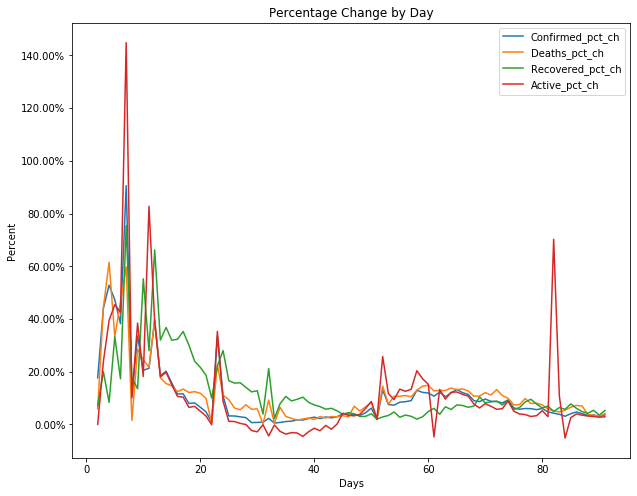

In [93]:
totals = df.groupby("Date").sum().reset_index(drop=True)
totals.index = totals.index + 1
totals['Fatality Rate'] = totals['Deaths'] / totals['Confirmed']

for col in totals.iloc[:,:-1]:
    totals[col+'_pct_ch'] = totals[col].pct_change()
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(totals.index[1:],totals.iloc[1:,-4:])
ax.set_title("Percentage Change by Day")
ax.set_ylabel("Percent")
ax.set_xlabel("Days")
ax.set_yticklabels(["{:.2f}%".format(x*100) for x in ax.get_yticks()])
ax.legend(totals.columns[-4:])
# plt.show()

for col in totals.iloc[:,:4]:
    totals[col+'_ch'] = totals[col].diff()
print(totals.columns)
t = pd.DataFrame(totals.iloc[-1,-4:]).T
t.columns = t.columns.str[:-3]
HTML("<h1 align='center'>Yesterday's Numbers</h1>"+t.style.set_table_styles(styles)\
.set_caption("Hover to highlight.")\
.format({"Confirmed":"{:,.0f}",
    "Deaths":"{:,.0f}",
    "Recovered":"{:,.0f}",
    "Active":"{:,.0f}"})\
.set_table_attributes('border="1" align="center" class="dataframe table table-hover table-bordered"')\
.hide_index()\
.render()
)

In [67]:
totals.iloc[:,:4].diff()

Confirmed   Deaths  Recovered   Active
1         NaN      NaN        NaN      NaN
2        98.0      1.0        2.0      0.0
3       288.0      8.0        6.0     95.0
4       497.0     16.0        3.0    195.0
5       680.0     14.0       13.0    313.0
..        ...      ...        ...      ...
87    87544.0  10021.0    26236.0  51287.0
88    77568.0   5688.0    23976.0  47904.0
89    83620.0   5534.0    31584.0  46502.0
90    70880.0   4942.0    21835.0  44103.0
91    88785.0   6998.0    34081.0  47706.0

[91 rows x 4 columns]

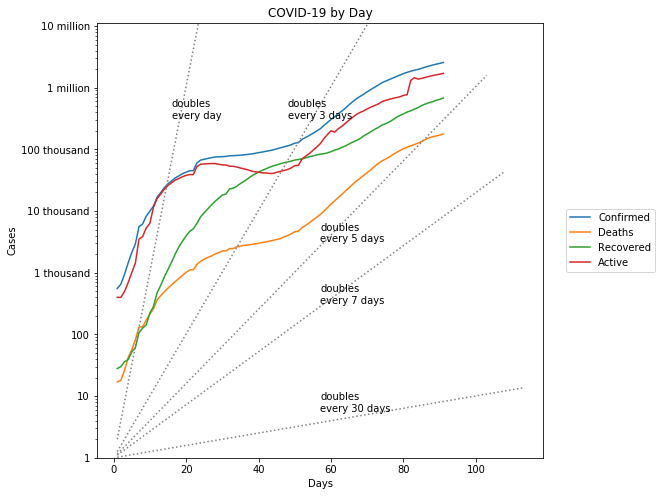

In [14]:
fig,ax = plt.subplots(figsize=(8,8))

totals.index = totals.index + 1
ax.plot(totals.index,totals)
for y in [1,3,5,7,30]:
    ax.plot(np.arange(1,ax.get_xlim()[1]),
             [2**(x * (1/y)) for x in np.arange(1,ax.get_xlim()[1])],
             linestyle=':',
             c="gray")

ax.set_ylim([1,totals.max().max()**1.1])

# ax.set_xlim([0,ax.get_xlim()[1]])
ax.set_yscale("log")
ax.annotate("doubles\nevery day",(16,10**5.5))
ax.annotate("doubles\nevery 3 days",(48,10**5.5))
ax.annotate("doubles\nevery 5 days",(57,10**3.5))
ax.annotate("doubles\nevery 7 days",(57,10**2.5))
ax.annotate("doubles\nevery 30 days",(57,10**0.75))
ax.set_ylabel("Cases")
ax.set_xlabel("Days")
ax.legend(labels=totals.columns,bbox_to_anchor=(1.04,0.5), loc="center left")
ax.set_yticklabels(["0","1","10","100","1 thousand","10 thousand","100 thousand","1 million","10 million","100 million","1 billion"])
ax.set_title("COVID-19 by Day")

# plt.savefig("covid.png",bbox_inches="tight")
plt.show()

In [15]:
rates_df = df.groupby("Country_Region").sum()
rates_df['Fatality Rate'] = rates_df['Deaths']/rates_df['Confirmed']*100


html_table = rates_df.loc[rates_df['Confirmed']>1000].nlargest(10,"Fatality Rate")


html_table = "<h1 align='center'>Highest Fatality Rates for Countries with over 1,000 Cases</h1>" + \
             html_table.style.set_table_styles(styles)\
                       .set_caption("Hover to highlight.")\
                       .format({"Confirmed":"{:,.0f}",
                                "Deaths":"{:,.0f}",
                                "Recovered":"{:,.0f}",
                                "Active":"{:,.0f}",
                                "Fatality Rate":"{:.2f}%"})\
                       .set_table_attributes('border="1" align="center" class="dataframe table table-hover table-bordered"')\
                       .render()
html_table

'<h1 align=\'center\'>Highest Fatality Rates for Countries with over 1,000 Cases</h1><style  type="text/css" >\n    #T_eefd157a_84ad_11ea_8c49_48f17f387e07 tr:hover {\n          background-color: #ffff99;\n    }    #T_eefd157a_84ad_11ea_8c49_48f17f387e07 th {\n          font-size: 150%;\n          text-align: center;\n    }    #T_eefd157a_84ad_11ea_8c49_48f17f387e07 td {\n          text-align: center;\n    }    #T_eefd157a_84ad_11ea_8c49_48f17f387e07 caption {\n          caption-side: bottom;\n    }    #T_eefd157a_84ad_11ea_8c49_48f17f387e07 table {\n          margin-left: auto;\n          margin-right: auto;\n    }</style><table id="T_eefd157a_84ad_11ea_8c49_48f17f387e07" border="1" align="center" class="dataframe table table-hover table-bordered"><caption>Hover to highlight.</caption><thead>    <tr>        <th class="blank level0" ></th>        <th class="col_heading level0 col0" >Confirmed</th>        <th class="col_heading level0 col1" >Deaths</th>        <th class="col_heading lev

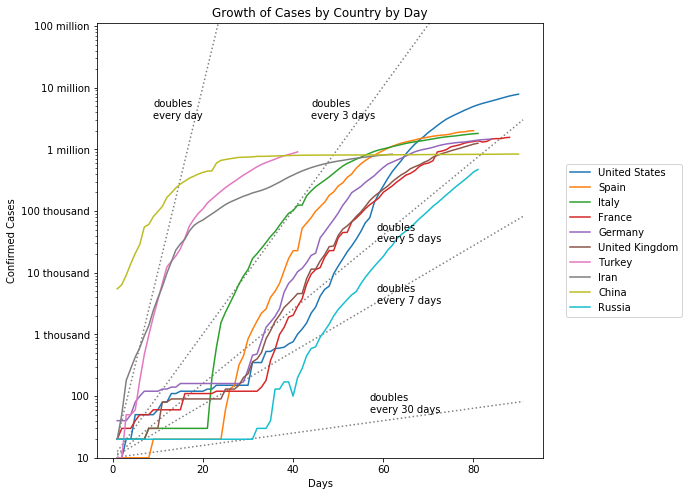

In [16]:
fig,ax = plt.subplots(figsize=(8,8))
for y in [1,3,5,7,30]:
    plt.plot(np.arange(1,max(country_counts.values())+1),
             [2**(x * (1/y)) for x in np.arange(1,max(country_counts.values())+1)],
             linestyle=':',
             c="gray")
for x in range(len(confirmed_df)):
    country_df = confirmed_df.iloc[x,:-1].dropna().reset_index(drop=True)
    country_df.index = country_df.index + 1
    country_df.plot(ax=ax)

ax.set_yscale("log")
ax.set_ylim([1,totals.max().max()**1.1])

ax.annotate("doubles\nevery day",(9,10**5.5))
ax.annotate("doubles\nevery 3 days",(44,10**5.5))
ax.annotate("doubles\nevery 5 days",(58.5,10**3.5))
ax.annotate("doubles\nevery 7 days",(58.5,10**2.5))
ax.annotate("doubles\nevery 30 days",(57,10**0.73))
ax.set_ylabel("Confirmed Cases")
ax.set_xlabel("Days")
ax.set_yticklabels(["1","10","100","1 thousand","10 thousand","100 thousand","1 million","10 million","100 million","1 billion"])
plt.title("Growth of Cases by Country by Day")
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
# plt.savefig("covid_confirmed.png",bbox_inches="tight")
plt.show()

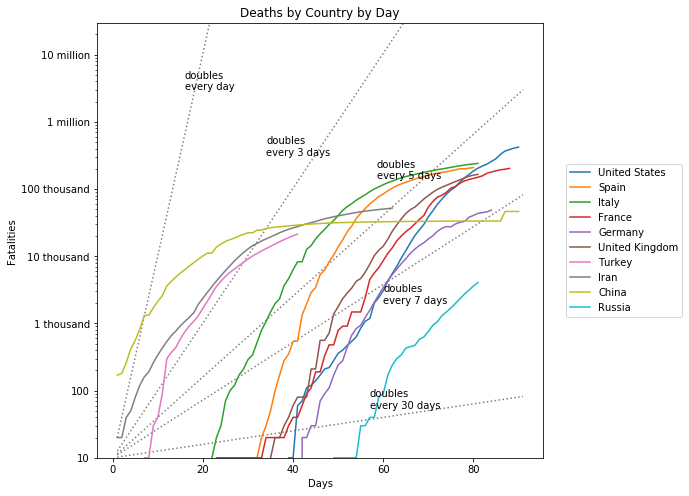

In [17]:
fig,ax = plt.subplots(figsize=(8,8))
for y in [1,3,5,7,30]:
    plt.plot(np.arange(1,max(country_counts.values())+1),
             [2**(x * (1/y)) for x in np.arange(1,max(country_counts.values())+1)],
             linestyle=':',
             c="gray")
for x in range(len(death_df)):
    country_df = death_df.iloc[x,:-1].dropna().reset_index(drop=True)
    country_df.index = country_df.index + 1
    country_df.plot(ax=ax)

ax.set_yscale("log")
ax.set_ylim([1,totals.max().max()**1.01])# print(plt.gca())
ax.annotate("doubles\nevery day",(16,ax.get_ylim()[1]*.1))
ax.annotate("doubles\nevery 3 days",(34,10**4.5))
ax.annotate("doubles\nevery 5 days",(58.5,10**4.15))
ax.annotate("doubles\nevery 7 days",(60,10**2.3))
ax.annotate("doubles\nevery 30 days",(57,10**0.73))
ax.set_ylabel("Fatalities")
ax.set_xlabel("Days")
ax.set_yticklabels(["1","10","100","1 thousand","10 thousand","100 thousand","1 million","10 million","100 million","1 billion"])
plt.title("Deaths by Country by Day")
ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
# plt.savefig("covid_dead.png",bbox_inches="tight")
plt.show()

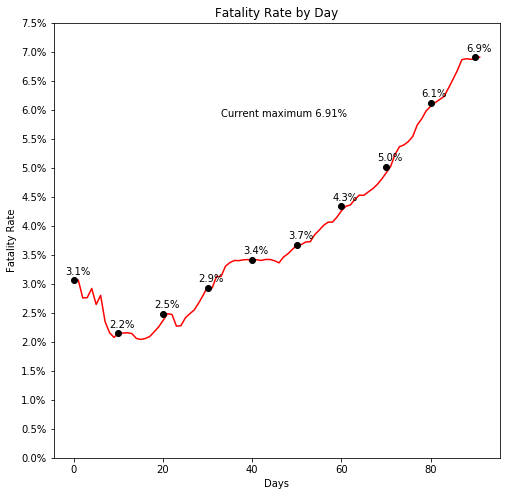

In [18]:
totals['Fatality Rate'] = totals['Deaths'] / totals['Confirmed']

fig,ax = plt.subplots(figsize=(8,8))
ax.plot(totals['Fatality Rate'],c="red")

ten_day_vals = range(0, round(max(totals.index)) + 1 ,10)
corresponding_day_vals = [totals["Fatality Rate"].iloc[x] for x in list(ten_day_vals)]

for x,y in zip(ten_day_vals,corresponding_day_vals):
    ax.plot(x,y,marker="o",c="black")
    ax.annotate("{:.1f}%".format(y*100),(x-2,y+0.001))

ax.set_yticks(np.arange(0,totals['Fatality Rate'].max()+0.01,0.005))
ax.set_yticklabels(list(map('{:.1f}%'.format,np.arange(0,totals['Fatality Rate'].max()+0.01,0.005)*100)))
# plt.legend([""],bbox_to_anchor=(1.04,0.5), loc="center left")
plt.title("Fatality Rate by Day")
plt.ylabel("Fatality Rate")
plt.xlabel("Days")
ax.annotate("Current maximum {:.2f}%".format(totals['Fatality Rate'].max()*100),
            (totals.index.max()/2.75,totals['Fatality Rate'][round(np.median(totals.index))]*1.75))

plt.show()

In [41]:
!pip install bokeh
from bokeh.models import (HoverTool, FactorRange, Plot, LinearAxis, Grid, Range1d)
from bokeh.models.glyphs import VBar
from bokeh.plotting import figure
from bokeh.charts import Bar
from bokeh.embed import components
from bokeh.models.sources import ColumnDataSource

  Created wheel for bokeh: filename=bokeh-2.0.2-cp37-none-any.whl size=9072549 sha256=a86be3ab3545ed34747a6551984bc2efb7462ad398cdfe9cde45f57db4de6f93
  Stored in directory: C:\Users\ryana\AppData\Local\pip\Cache\wheels\a3\5e\7d\49405a043a4714a1b66bb7a16dfe16a1f0db9217baac7c4fe3
Successfully built bokeh


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


ModuleNotFoundError: No module named 'bokeh.charts'